In [53]:
import numpy as np
import pandas as pd
import random

# Number of data points (daily data for 365 days)
num_data_points = 365

# Generate timestamps
timestamps = pd.date_range(start="2025-01-01", periods=num_data_points, freq="D")

# Generate synthetic weather data
temperature = np.random.uniform(low=5, high=40, size=num_data_points)  # °C
humidity = np.random.uniform(low=30, high=90, size=num_data_points)    # %
wind_speed = np.random.uniform(low=0, high=15, size=num_data_points)   # m/s
solar_radiation = [
    max(0, 1000 * np.sin((np.pi / 12) * (hour % 24 - 6)))  # Simulate solar peak at noon
    for hour in range(num_data_points)
]

# Generate synthetic energy usage data
base_usage = 300  # Base load (kWh)
energy_usage = [
    base_usage +
    50 * (1 if 6 <= (hour % 24) < 18 else 0) +  # Daytime usage spike
    -10 * (temp > 30) + 10 * (temp < 15) +      # Temperature effects
    random.gauss(0, 50)                        # Random noise
    for hour, temp in enumerate(temperature)
]

# Create the dataset
data = {
    "Timestamp": timestamps,
    "Temperature (°C)": temperature,
    "Humidity (%)": humidity,
    "Wind Speed (m/s)": wind_speed,
    "Solar Radiation (W/m²)": np.random.uniform(50, 1000, num_data_points),
    "Energy Usage (kWh)": energy_usage
}

dataset = pd.DataFrame(data)

# Save to a CSV file
file_path = "data.csv"
dataset.to_csv(file_path, index=False)

file_path

'data.csv'

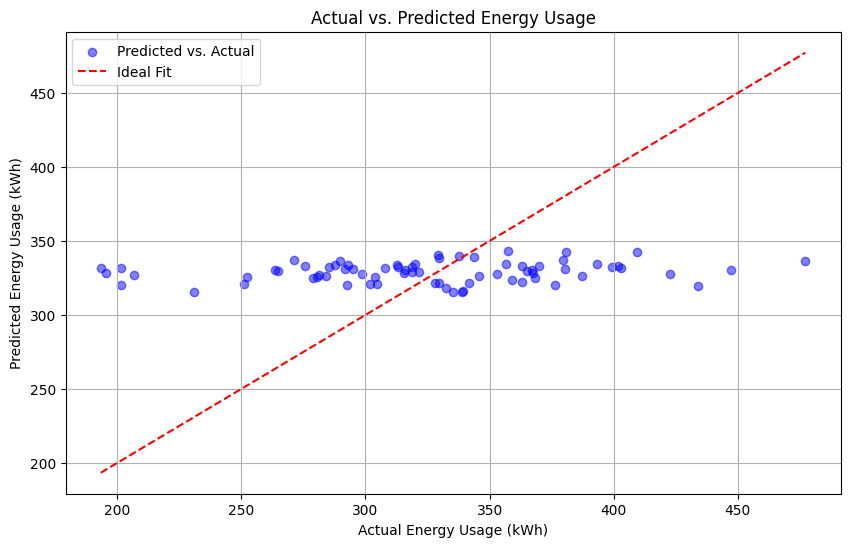

(3366.426291166709, 0.024532269485128544)

In [54]:
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Load the dataset
df = pd.read_csv(file_path)

# Features and target variable
X = df[["Temperature (°C)", "Humidity (%)", "Wind Speed (m/s)", "Solar Radiation (W/m²)"]]
y = df["Energy Usage (kWh)"]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a linear regression model
model = LinearRegression()

# Train the model
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Plot actual vs. predicted energy usage
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, color='blue', alpha=0.5, label='Predicted vs. Actual')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', label='Ideal Fit')
plt.xlabel("Actual Energy Usage (kWh)")
plt.ylabel("Predicted Energy Usage (kWh)")
plt.title("Actual vs. Predicted Energy Usage")
plt.legend()
plt.grid(True)
plt.show()

# Display model evaluation metrics
mse, r2


         date  temperature   humidity  rainfall  wind_speed day_type  \
0  2018-01-01    26.236204  57.121149       0.1    8.183652  Weekday   
1  2018-01-02    43.521429  22.936586       0.0    6.587585  Weekday   
2  2018-01-03    36.959818  87.794214       0.1   13.867551  Weekday   
3  2018-01-04    32.959755  75.909993       0.0   15.324909  Weekend   
4  2018-01-05    19.680559  40.497543       0.0    6.081893  Weekday   

  month_name  consumption  
0    January   108.761866  
1    January    69.784364  
2    January   113.168115  
3    January    99.441498  
4    January   119.203466  
Model Performance:
Linear Regression -> MSE: 113.55, R²: 0.74
Ridge Regression -> MSE: 113.53, R²: 0.74
Lasso Regression -> MSE: 115.43, R²: 0.74
Random Forest -> MSE: 123.42, R²: 0.72
Best Ridge Alpha: {'alpha': 1.0}
Best Lasso Alpha: {'alpha': 0.1}
Polynomial Ridge Regression -> MSE: 116.60, R²: 0.73


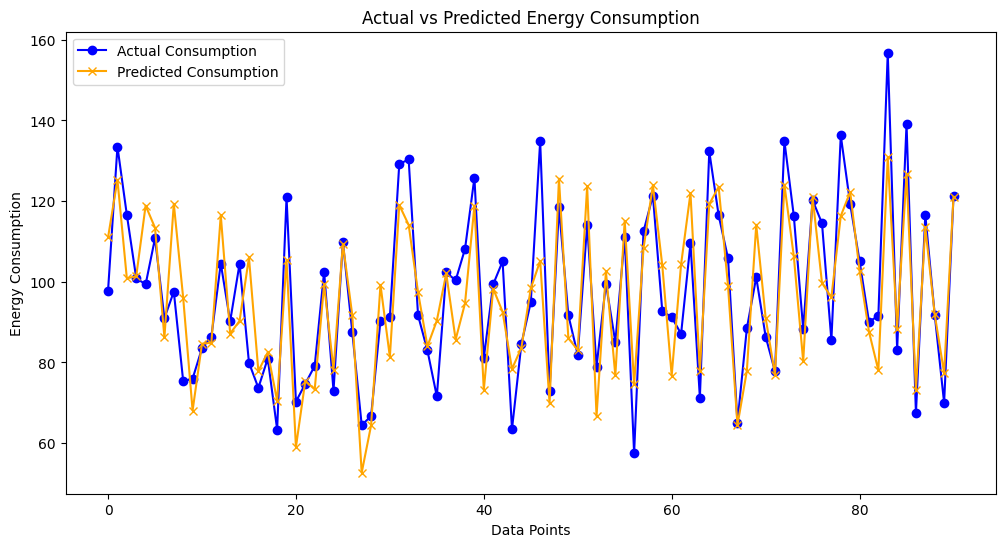

In [55]:
# Import Required Libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import Ridge, Lasso, LinearRegression
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, LabelEncoder
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt

# Load Dataset
data = pd.read_csv('../datasets/new_data.csv')  # Replace with your dataset file path
print(data.head())

# Data Preprocessing
# Drop the 'date' column as it's not directly useful for modeling
if 'date' in data.columns:
    data.drop(columns=['date'], inplace=True)

# Handling Categorical Variables (if any)
label_encoder_month = LabelEncoder()
if 'month_name' in data.columns:
    data['month_name'] = label_encoder_month.fit_transform(data['month_name'])

label_encoder_day = LabelEncoder()
if 'day_type' in data.columns:  # Assume 'day_type' column indicates 'weekday' or 'weekend'
    data['day_type'] = label_encoder_day.fit_transform(data['day_type'])

# Handle Missing Data
# Fill numeric columns with their mean
data.fillna(data.select_dtypes(include=[np.number]).mean(), inplace=True)

# Feature Engineering
# Adding Lag Features for Time-Series (if data has date/time column)
if 'consumption' in data.columns:
    data['lag_1'] = data['consumption'].shift(1)
    data['lag_2'] = data['consumption'].shift(2)
    data['lag_7'] = data['consumption'].shift(7)
    data.dropna(inplace=True)  # Drop rows with NaN values after shifting

# Define Features (X) and Target (y)
X = data.drop(columns=['consumption'])  # Features
y = data['consumption']  # Target Variable

# Split the Dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05, random_state=42)

# Standardize Features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train Multiple Models for Comparison
models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(),
    'Lasso Regression': Lasso(),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=15)
}

results = {}
for name, model in models.items():
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    results[name] = {'MSE': mse, 'R²': r2}

# Display Model Performance
print("Model Performance:")
for model, metrics in results.items():
    print(f"{model} -> MSE: {metrics['MSE']:.2f}, R²: {metrics['R²']:.2f}")

# Hyperparameter Tuning for Ridge and Lasso
param_grid = {'alpha': [0.1, 1.0, 10.0, 100.0]}
ridge = Ridge()
lasso = Lasso()

ridge_search = GridSearchCV(ridge, param_grid, cv=5, scoring='neg_mean_squared_error')
lasso_search = GridSearchCV(lasso, param_grid, cv=5, scoring='neg_mean_squared_error')

ridge_search.fit(X_train_scaled, y_train)
lasso_search.fit(X_train_scaled, y_train)

# Best Parameters
print(f"Best Ridge Alpha: {ridge_search.best_params_}")
print(f"Best Lasso Alpha: {lasso_search.best_params_}")

# Final Model: Polynomial Ridge Regression
poly = PolynomialFeatures(degree=2, include_bias=False)
X_train_poly = poly.fit_transform(X_train_scaled)
X_test_poly = poly.transform(X_test_scaled)

ridge_final = Ridge(alpha=ridge_search.best_params_['alpha'])
ridge_final.fit(X_train_poly, y_train)
y_pred_poly = ridge_final.predict(X_test_poly)

# Evaluate Final Model
mse_poly = mean_squared_error(y_test, y_pred_poly)
r2_poly = r2_score(y_test, y_pred_poly)
print(f"Polynomial Ridge Regression -> MSE: {mse_poly:.2f}, R²: {r2_poly:.2f}")

# Visualize Actual vs Predicted
plt.figure(figsize=(12, 6))
plt.plot(y_test.values, label='Actual Consumption', color='blue', marker='o')
plt.plot(y_pred_poly, label='Predicted Consumption', color='orange', marker='x')
plt.title('Actual vs Predicted Energy Consumption')
plt.xlabel('Data Points')
plt.ylabel('Energy Consumption')
plt.legend()
plt.show()


In [56]:
import pandas as pd
import numpy as np

# Set parameters for simulation
np.random.seed(42)
start_date = "2024-01-01"
end_date = "2024-12-31"
freq = "15T"  # 15-minute intervals

# Generate timestamps
timestamps = pd.date_range(start=start_date, end=end_date, freq=freq)

# Generate energy consumption (base consumption with random variations)
base_consumption = 3  # kWh, average consumption per 15 minutes
daily_pattern = [1.5, 2, 3.5, 4, 3.5, 2, 1.5]  # Morning, midday, evening spikes

energy_consumed = []
for ts in timestamps:
    hour = ts.hour
    if 0 <= hour < 6:  # Nighttime (lower usage)
        base = daily_pattern[0]
    elif 6 <= hour < 12:  # Morning (increasing usage)
        base = daily_pattern[1]
    elif 12 <= hour < 18:  # Afternoon peak
        base = daily_pattern[2]
    elif 18 <= hour < 21:  # Evening high peak
        base = daily_pattern[3]
    else:  # Late evening
        base = daily_pattern[4]
    variation = np.random.uniform(-0.5, 0.5)  # Random variation
    energy_consumed.append(base + variation)

# Add external features
temperature = 20 + np.random.uniform(-5, 5, size=len(timestamps))  # Random temp
weekday = [1 if ts.weekday() < 5 else 0 for ts in timestamps]  # Weekday or weekend
hour_of_day = [ts.hour for ts in timestamps]
holiday = [1 if ts.weekday() == 6 else 0 for ts in timestamps]  # Simulate Sundays as holidays

# Create DataFrame
data = pd.DataFrame({
    "timestamp": timestamps,
    "energy_consumed": energy_consumed,
    "temperature": temperature,
    "weekday": weekday,
    "hour_of_day": hour_of_day,
    "holiday": holiday,
})

# Save to CSV
csv_file_path = '../datasets/energy_prediction_data.csv'
data.to_csv(csv_file_path, index=False)

csv_file_path


C:\Users\Acer\AppData\Local\Temp\ipykernel_4644\2484885208.py:11: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  timestamps = pd.date_range(start=start_date, end=end_date, freq=freq)


'../datasets/energy_prediction_data.csv'

C:\Users\Acer\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 15min will be used.
  self._init_dates(dates, freq)
C:\Users\Acer\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 15min will be used.
  self._init_dates(dates, freq)
C:\Users\Acer\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 15min will be used.
  self._init_dates(dates, freq)


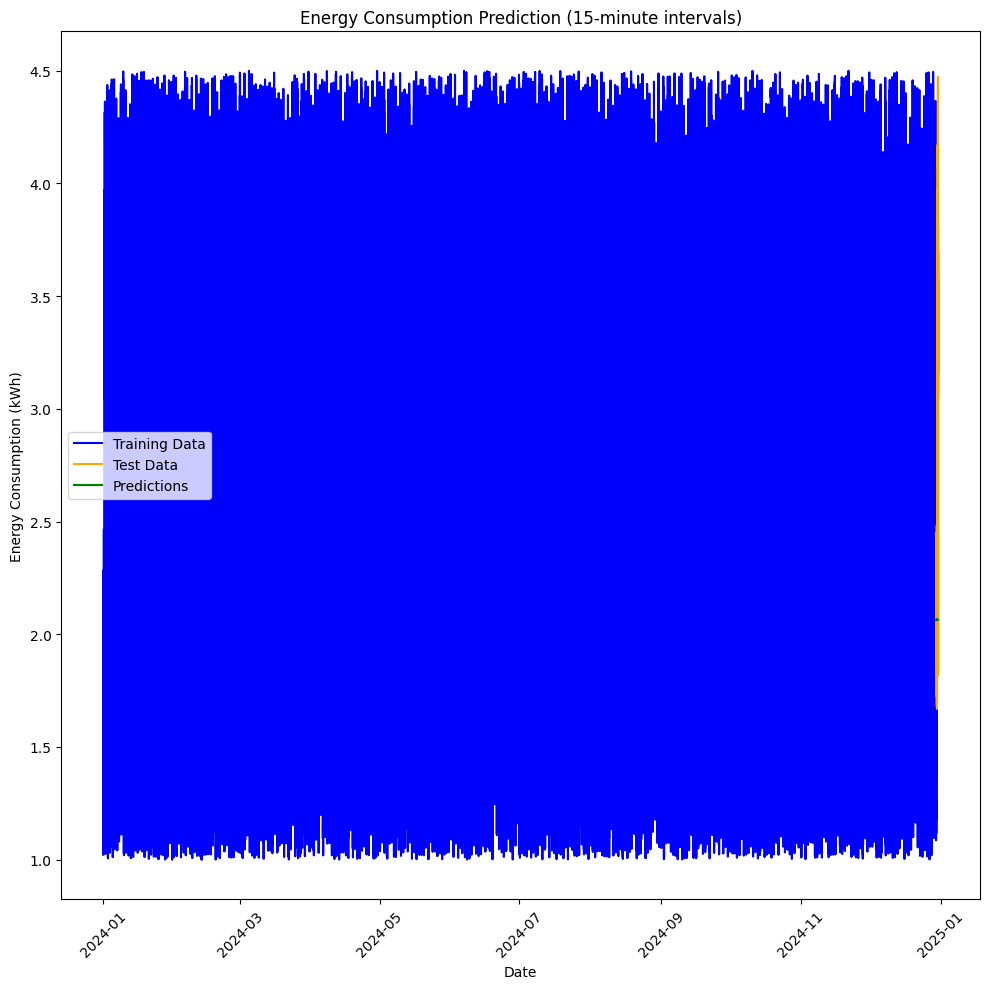

In [57]:
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA

# Prepare data for prediction (using energy_consumed column)
data['timestamp'] = pd.to_datetime(data['timestamp'])
data.set_index('timestamp', inplace=True)
train_data = data['energy_consumed'][:-72]  # Use all data except the last 72 points for training
test_data = data['energy_consumed'][-72:]   # Use the last 72 points for testing

# Fit ARIMA model
model = ARIMA(train_data, order=(5, 1, 0))  # Adjust the order based on your data
model_fit = model.fit()

# Make predictions
predictions = model_fit.forecast(steps=len(test_data))

# Plot the results
plt.figure(figsize=(10, 10))
plt.plot(train_data.index, train_data, label='Training Data', color='blue')
plt.plot(test_data.index, test_data, label='Test Data', color='orange')
plt.plot(test_data.index, predictions, label='Predictions', color='green')
plt.title('Energy Consumption Prediction (15-minute intervals)')
plt.xlabel('Date')
plt.ylabel('Energy Consumption (kWh)')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


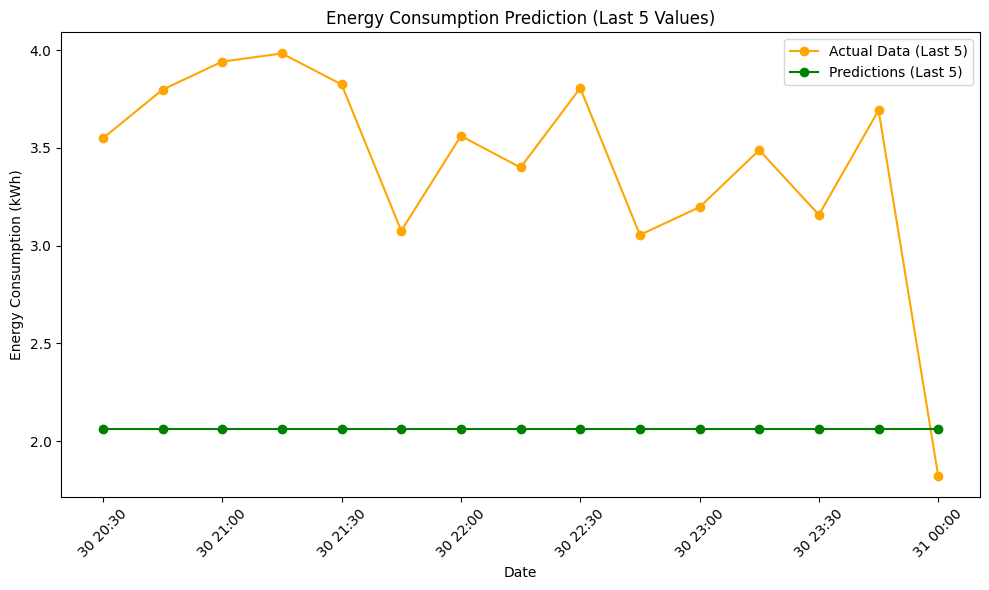

In [58]:
# Select the last 5 data points for both test and predictions
last_5_actual = test_data[-15:]
last_5_predictions = predictions[-15:]

# Plot the last 5 values
plt.figure(figsize=(10, 6))
plt.plot(last_5_actual.index, last_5_actual, label='Actual Data (Last 5)', color='orange', marker='o')
plt.plot(last_5_actual.index, last_5_predictions, label='Predictions (Last 5)', color='green', marker='o')
plt.title('Energy Consumption Prediction (Last 5 Values)')
plt.xlabel('Date')
plt.ylabel('Energy Consumption (kWh)')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


             timestamp  energy_consumed  temperature  weekday  hour_of_day  \
0  2024-01-01 00:00:00         1.374540    22.045199        1            0   
1  2024-01-01 00:15:00         1.950714    19.402837        1            0   
2  2024-01-01 00:30:00         1.731994    23.783877        1            0   
3  2024-01-01 00:45:00         1.598658    16.376861        1            0   
4  2024-01-01 01:00:00         1.156019    17.603386        1            1   

   holiday  
0        0  
1        0  
2        0  
3        0  
4        0  
Model Performance:
Linear Regression -> MSE: 0.17, R²: 0.84
Ridge Regression -> MSE: 0.17, R²: 0.84
Lasso Regression -> MSE: 1.02, R²: -0.00
Random Forest -> MSE: 0.09, R²: 0.91
Best Ridge Alpha: {'alpha': 1.0}
Best Lasso Alpha: {'alpha': 0.1}
Polynomial Ridge Regression -> MSE: 0.14, R²: 0.86


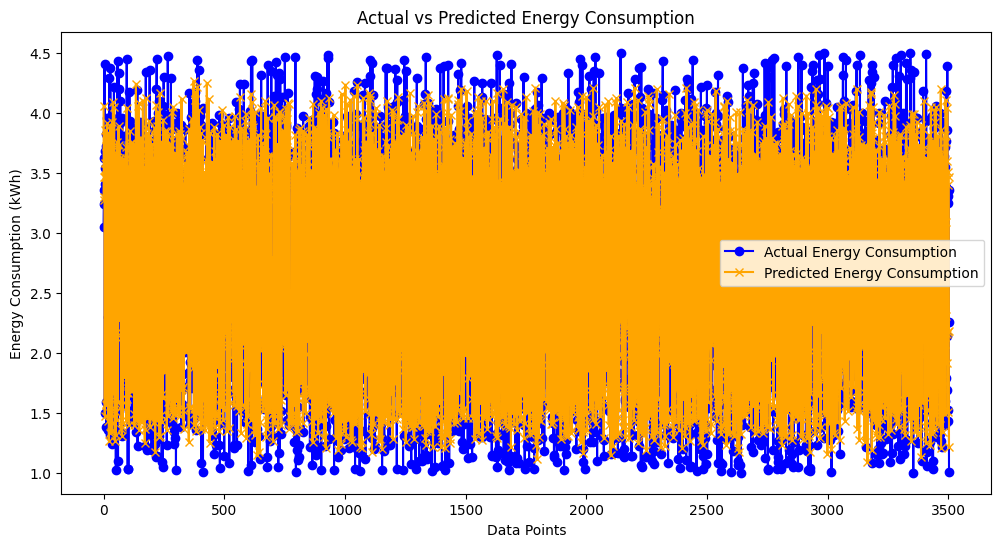

In [59]:
# Import Required Libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import Ridge, Lasso, LinearRegression
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, LabelEncoder
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt

# Load Dataset
data = pd.read_csv('../datasets/energy_prediction_data.csv')  # Replace with your dataset file path
print(data.head())

# Data Preprocessing
# Drop the 'timestamp' column as it's not directly useful for modeling
data.drop(columns=['timestamp'], inplace=True)

# Handling Categorical Variables (if any)
# 'holiday' is binary, no need for label encoding, but we can convert it if necessary
# 'hour_of_day' and 'weekday' are already numeric, so we don't need encoding

# Handle Missing Data
# Fill numeric columns with their mean
data.fillna(data.select_dtypes(include=[np.number]).mean(), inplace=True)

# Feature Engineering
# Adding Lag Features for Time-Series (if 'energy_consumed' is the target variable)
data['lag_1'] = data['energy_consumed'].shift(1)
data['lag_2'] = data['energy_consumed'].shift(2)
data['lag_7'] = data['energy_consumed'].shift(7)
data.dropna(inplace=True)  # Drop rows with NaN values after shifting

# Define Features (X) and Target (y)
X = data.drop(columns=['energy_consumed'])  # Features
y = data['energy_consumed']  # Target Variable

# Split the Dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=35050)

# Standardize Features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train Multiple Models for Comparison
models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(),
    'Lasso Regression': Lasso(),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=15)
}

results = {}
for name, model in models.items():
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    results[name] = {'MSE': mse, 'R²': r2}

# Display Model Performance
print("Model Performance:")
for model, metrics in results.items():
    print(f"{model} -> MSE: {metrics['MSE']:.2f}, R²: {metrics['R²']:.2f}")

# Hyperparameter Tuning for Ridge and Lasso
param_grid = {'alpha': [0.1, 1.0, 10.0, 100.0]}
ridge = Ridge()
lasso = Lasso()

ridge_search = GridSearchCV(ridge, param_grid, cv=5, scoring='neg_mean_squared_error')
lasso_search = GridSearchCV(lasso, param_grid, cv=5, scoring='neg_mean_squared_error')

ridge_search.fit(X_train_scaled, y_train)
lasso_search.fit(X_train_scaled, y_train)

# Best Parameters
print(f"Best Ridge Alpha: {ridge_search.best_params_}")
print(f"Best Lasso Alpha: {lasso_search.best_params_}")

# Final Model: Polynomial Ridge Regression
poly = PolynomialFeatures(degree=2, include_bias=False)
X_train_poly = poly.fit_transform(X_train_scaled)
X_test_poly = poly.transform(X_test_scaled)

ridge_final = Ridge(alpha=ridge_search.best_params_['alpha'])
ridge_final.fit(X_train_poly, y_train)
y_pred_poly = ridge_final.predict(X_test_poly)

# Evaluate Final Model
mse_poly = mean_squared_error(y_test, y_pred_poly)
r2_poly = r2_score(y_test, y_pred_poly)
print(f"Polynomial Ridge Regression -> MSE: {mse_poly:.2f}, R²: {r2_poly:.2f}")

# Visualize Actual vs Predicted
plt.figure(figsize=(12, 6))
plt.plot(y_test.values, label='Actual Energy Consumption', color='blue', marker='o')
plt.plot(y_pred_poly, label='Predicted Energy Consumption', color='orange', marker='x')
plt.title('Actual vs Predicted Energy Consumption')
plt.xlabel('Data Points')
plt.ylabel('Energy Consumption (kWh)')
plt.legend()
plt.show()


In [ ]:
# Import Required Libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import Ridge, Lasso, LinearRegression
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, LabelEncoder
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt

# Load Dataset
data = pd.read_csv('../datasets/energy_prediction_data.csv')  # Replace with your dataset file path
print(data.head())

# Data Preprocessing
# Ensure the necessary columns exist
if 'timestamp' in data.columns:
    data.drop(columns=['timestamp'], inplace=True)

# Handle Missing Data
# Fill numeric columns with their mean (handle NaNs)
data.fillna(data.select_dtypes(include=[np.number]).mean(), inplace=True)

# Feature Engineering: Adding Lag Features for Time-Series (assuming 'energy_consumed' is the target variable)
if 'energy_consumed' in data.columns:
    data['lag_1'] = data['energy_consumed'].shift(1)
    data['lag_2'] = data['energy_consumed'].shift(2)
    data['lag_7'] = data['energy_consumed'].shift(7)
    data.dropna(inplace=True)  # Drop rows with NaN values after shifting

# Define Features (X) and Target (y)
X = data.drop(columns=['energy_consumed'])  # Features
y = data['energy_consumed']  # Target Variable

# Split the Dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1, random_state=35050)

# Standardize Features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train Multiple Models for Comparison
models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(),
    'Lasso Regression': Lasso(),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=15)
}

results = {}
for name, model in models.items():
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    results[name] = {'MSE': mse, 'R²': r2}

# Display Model Performance
print("Model Performance:")
for model, metrics in results.items():
    print(f"{model} -> MSE: {metrics['MSE']:.2f}, R²: {metrics['R²']:.2f}")

# Hyperparameter Tuning for Ridge and Lasso
param_grid = {'alpha': [0.1, 1.0, 10.0, 100.0]}
ridge = Ridge()
lasso = Lasso()

ridge_search = GridSearchCV(ridge, param_grid, cv=5, scoring='neg_mean_squared_error')
lasso_search = GridSearchCV(lasso, param_grid, cv=5, scoring='neg_mean_squared_error')

ridge_search.fit(X_train_scaled, y_train)
lasso_search.fit(X_train_scaled, y_train)

# Best Parameters
print(f"Best Ridge Alpha: {ridge_search.best_params_}")
print(f"Best Lasso Alpha: {lasso_search.best_params_}")

# Final Model: Polynomial Ridge Regression
poly = PolynomialFeatures(degree=2, include_bias=False)
X_train_poly = poly.fit_transform(X_train_scaled)
X_test_poly = poly.transform(X_test_scaled)

ridge_final = Ridge(alpha=ridge_search.best_params_['alpha'])
ridge_final.fit(X_train_poly, y_train)
y_pred_poly = ridge_final.predict(X_test_poly)

# Evaluate Final Model
mse_poly = mean_squared_error(y_test, y_pred_poly)
r2_poly = r2_score(y_test, y_pred_poly)
print(f"Polynomial Ridge Regression -> MSE: {mse_poly:.2f}, R²: {r2_poly:.2f}")

# Visualize Actual vs Predicted
plt.figure(figsize=(12, 6))
plt.plot(y_test.values, label='Actual Energy Consumption', color='blue', marker='o')
plt.plot(y_pred_poly, label='Predicted Energy Consumption', color='orange', marker='x')
plt.title('Actual vs Predicted Energy Consumption')
plt.xlabel('Data Points')
plt.ylabel('Energy Consumption (kWh)')
plt.legend()
plt.show()


             timestamp  energy_consumed  temperature  weekday  hour_of_day  \
0  2024-01-01 00:00:00         1.374540    22.045199        1            0   
1  2024-01-01 00:15:00         1.950714    19.402837        1            0   
2  2024-01-01 00:30:00         1.731994    23.783877        1            0   
3  2024-01-01 00:45:00         1.598658    16.376861        1            0   
4  2024-01-01 01:00:00         1.156019    17.603386        1            1   

   holiday  
0        0  
1        0  
2        0  
3        0  
4        0  


KeyboardInterrupt: 

             timestamp  energy_consumed  temperature  weekday  hour_of_day  \
0  2024-01-01 00:00:00         1.374540    22.045199        1            0   
1  2024-01-01 00:15:00         1.950714    19.402837        1            0   
2  2024-01-01 00:30:00         1.731994    23.783877        1            0   
3  2024-01-01 00:45:00         1.598658    16.376861        1            0   
4  2024-01-01 01:00:00         1.156019    17.603386        1            1   

   holiday  
0        0  
1        0  
2        0  
3        0  
4        0  
Model Performance:
Linear Regression -> MSE: 0.17, R²: 0.83
Ridge Regression -> MSE: 0.17, R²: 0.83
Lasso Regression -> MSE: 1.00, R²: -0.00
Random Forest -> MSE: 0.08, R²: 0.92
Best Ridge Alpha: {'alpha': 10.0}
Best Lasso Alpha: {'alpha': 0.1}
Polynomial Ridge Regression -> MSE: 0.14, R²: 0.86


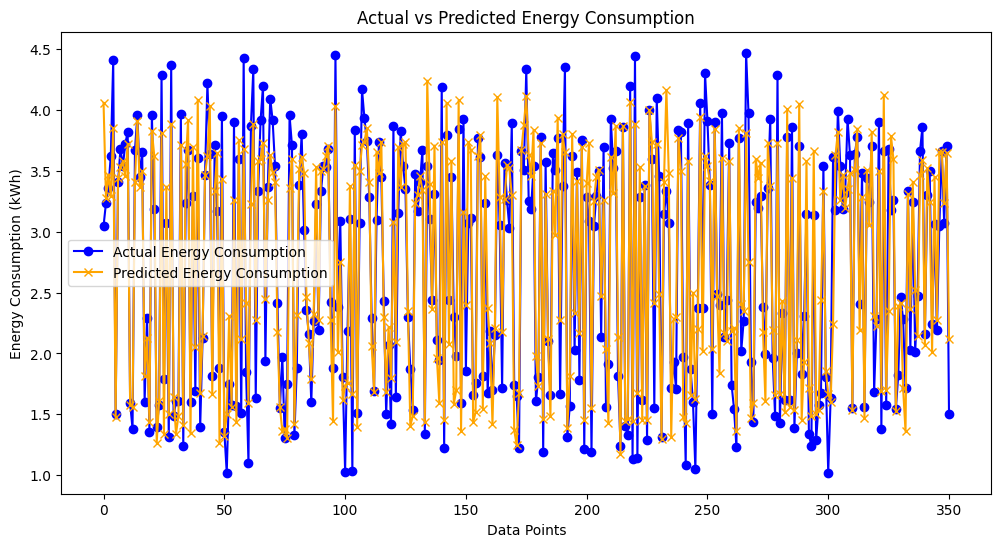

C:\Users\Acer\AppData\Local\Temp\ipykernel_4644\4174266668.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  last_data_point['lag_1'] = data['energy_consumed'].tail(1).values[0]
C:\Users\Acer\AppData\Local\Temp\ipykernel_4644\4174266668.py:112: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  last_data_point['lag_15'] = data['energy_consumed'].shift(1).tail(1).values[0]
C:\Users\Acer\AppData\Local\Temp\ipykernel_4644\4174266668.py:113: SettingWithCopyWarning: 
A value is trying to be set on a copy of a sli

ValueError: Expected a 2-dimensional container but got <class 'pandas.core.series.Series'> instead. Pass a DataFrame containing a single row (i.e. single sample) or a single column (i.e. single feature) instead.

In [ ]:
# Import Required Libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import Ridge, Lasso, LinearRegression
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, LabelEncoder
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt

# Load Dataset
data = pd.read_csv('../datasets/energy_prediction_data.csv')  # Replace with your dataset file path
print(data.head())

# Data Preprocessing
# Drop the 'timestamp' column as it's not directly useful for modeling
data.drop(columns=['timestamp'], inplace=True)

# Handling Categorical Variables (if any)
# 'holiday' is binary, no need for label encoding, but we can convert it if necessary
# 'hour_of_day' and 'weekday' are already numeric, so we don't need encoding

# Handle Missing Data
# Fill numeric columns with their mean
data.fillna(data.select_dtypes(include=[np.number]).mean(), inplace=True)

# Feature Engineering
# Adding Lag Features for Time-Series (if 'energy_consumed' is the target variable)
data['lag_1'] = data['energy_consumed'].shift(1)
data['lag_2'] = data['energy_consumed'].shift(2)
data['lag_7'] = data['energy_consumed'].shift(7)
data.dropna(inplace=True)  # Drop rows with NaN values after shifting

# Define Features (X) and Target (y)
X = data.drop(columns=['energy_consumed'])  # Features
y = data['energy_consumed']  # Target Variable

# Split the Dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.01, random_state=35050)

# Standardize Features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train Multiple Models for Comparison
models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(),
    'Lasso Regression': Lasso(),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=15)
}

results = {}
for name, model in models.items():
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    results[name] = {'MSE': mse, 'R²': r2}

# Display Model Performance
print("Model Performance:")
for model, metrics in results.items():
    print(f"{model} -> MSE: {metrics['MSE']:.2f}, R²: {metrics['R²']:.2f}")

# Hyperparameter Tuning for Ridge and Lasso
param_grid = {'alpha': [0.1, 1.0, 10.0, 100.0]}
ridge = Ridge()
lasso = Lasso()

ridge_search = GridSearchCV(ridge, param_grid, cv=5, scoring='neg_mean_squared_error')
lasso_search = GridSearchCV(lasso, param_grid, cv=5, scoring='neg_mean_squared_error')

ridge_search.fit(X_train_scaled, y_train)
lasso_search.fit(X_train_scaled, y_train)

# Best Parameters
print(f"Best Ridge Alpha: {ridge_search.best_params_}")
print(f"Best Lasso Alpha: {lasso_search.best_params_}")

# Final Model: Polynomial Ridge Regression
poly = PolynomialFeatures(degree=2, include_bias=False)
X_train_poly = poly.fit_transform(X_train_scaled)
X_test_poly = poly.transform(X_test_scaled)

ridge_final = Ridge(alpha=ridge_search.best_params_['alpha'])
ridge_final.fit(X_train_poly, y_train)
y_pred_poly = ridge_final.predict(X_test_poly)

# Evaluate Final Model
mse_poly = mean_squared_error(y_test, y_pred_poly)
r2_poly = r2_score(y_test, y_pred_poly)
print(f"Polynomial Ridge Regression -> MSE: {mse_poly:.2f}, R²: {r2_poly:.2f}")

# Visualize Actual vs Predicted
plt.figure(figsize=(12, 6))
plt.plot(y_test.values, label='Actual Energy Consumption', color='blue', marker='o')
plt.plot(y_pred_poly, label='Predicted Energy Consumption', color='orange', marker='x')
plt.title('Actual vs Predicted Energy Consumption')
plt.xlabel('Data Points')
plt.ylabel('Energy Consumption (kWh)')
plt.legend()
plt.show()

# Make Future Prediction (next 15 minutes)
# Assuming last data point is the input for prediction
last_data_point = X.tail(1)  # Get the last row from the feature set

# Apply the same feature engineering (lag features) to the new input data
last_data_point['lag_1'] = data['energy_consumed'].tail(1).values[0]
last_data_point['lag_2'] = data['energy_consumed'].shift(1).tail(1).values[0]
last_data_point['lag_7'] = data['energy_consumed'].shift(7).tail(1).values[0]

# Scale the new input data
last_data_point_scaled = scaler.transform(last_data_point)

# Apply the same PolynomialFeature transformation to the new input data
last_data_point_poly = poly.transform(last_data_point_scaled)

# Predict the next energy consumption value (next 15 minutes)
next_prediction = ridge_final.predict(last_data_point_poly)
print(f"Predicted energy consumption for the next 15 minutes: {next_prediction[0]} kWh")


In [63]:
# Make Future Prediction (next 30 minutes)
# Assuming last data point is the input for prediction
last_data_point = X.tail(1)  # Get the last row from the feature set

# # Apply the same feature engineering (lag features) to the new input data
# last_data_point['lag_1'] = data['energy_consumed'].tail(1).values[0]
# last_data_point['lag_2'] = data['energy_consumed'].shift(1).tail(1).values[0]
# last_data_point['lag_7'] = data['energy_consumed'].shift(7).tail(1).values[0]

# If you want to predict the energy consumption for the next 30 minutes:
# For example, use a lag of 2 (if the time interval is 15 minutes)
last_data_point['lag_30'] = data['energy_consumed'].shift(2).tail(1).values[0]

# Scale the new input data
last_data_point_scaled = scaler.transform(last_data_point)

# Apply the same PolynomialFeature transformation to the new input data
last_data_point_poly = poly.transform(last_data_point_scaled)

# Predict the next energy consumption value (next 30 minutes)
next_prediction = ridge_final.predict(last_data_point_poly)
print(f"Predicted energy consumption for the next 30 minutes: {next_prediction[0]} kWh")


C:\Users\Acer\AppData\Local\Temp\ipykernel_4644\1971432415.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  last_data_point['lag_30'] = data['energy_consumed'].shift(2).tail(1).values[0]


ValueError: The feature names should match those that were passed during fit.
Feature names unseen at fit time:
- lag_30
